In [1]:
from invisible_cities.database.load_db import DataSiPM

from csth.images.imageDataFrame        import imageDataFrame

import csth.utils.cepeak_pmaps  as cpkpmap
import csth.utils.pmaps         as pmapdf
import csth.utils.cepeak        as cpk
import csth.images.voxelization as vx
import csth.images.blob         as bl

from csth.images.IMAGE import IMAGE

import numpy                as np
import pandas               as pd
import matplotlib.pyplot    as plt
import matplotlib.patches  as patches
import matplotlib.gridspec as gridspec

from scipy                   import optimize
from scipy.integrate         import quad

In [2]:
# Plotting style
figure_size  = 9, 5
#default_cmap = "viridis"

plt.rcParams["figure.figsize"]  = figure_size
plt.rcParams["axes.facecolor"]  = 'ghostwhite'
plt.rcParams["grid.color"    ]  = 'lightgrey'
plt.rcParams["axes.formatter.limits"] = -4, 4
plt.rcParams["font.family"]='serif'

#plt.style.use(plt.style.available[10])

#set number of bins
nbins = 100

In [3]:
def cepeak(run_number, input_filename, correction_filename, evt, pk, q0min):
    pmaps, runinfo        = cpkpmap.data(input_filename)
    
    calibrate, xpos, ypos = cpkpmap.tools(correction_filename, run_number)
    
    pmap = pmapdf.get_eventpeak(pmaps, evt, pk)
    
    epk   = cpkpmap.epeak(pmap, xpos, ypos, q0min)
    if (epk is None): 
        print('No epeak!!')

    cepk  = cpk.cepeak(epk, calibrate)

    return epk, cepk

# 1. EVENT SELECTION

In [4]:
run = 6482
data = pd.HDFStore(f'../DATA/cepks_{run}_0000_11999_6q0min.h5')['/esum']

#photopeak region for run
a, b = 4.1e5, 4.5e5
thds = data[(a<data['e'])&(data['e']<b)]

evts, pks, locs = thds['event'].values, thds['peak'].values, thds['location'].values

## Example of how to select event

In [5]:
typo = 'Tlds'
i=0
evt, pk, loc = evts[i], pks[i], locs[i]
loc = '{:04}'.format(loc)

In [6]:
correction_filename = f'/home/gonzalo/Documentos/NEXT/DATA/maps/kr_corrections_run{run}.h5'
#input_filename  = f'/home/gonzalo/Documentos/NEXT/CsThNB/GDL/selected_pmaps/{run}/pmaps_{loc}_{run}_{typo}.h5'
input_filename = f'/home/gonzalo/Documentos/NEXT/DATA/{run}/pmaps_{loc}_{run}_trigger2_v0.9.9_20181011_krth1300.h5'


epk, cepk = cepeak(run, input_filename, correction_filename, evt, pk, q0min=6)
xij, yij, zij, eij = cepk.xij, cepk.yij, cepk.zij, cepk.eij

processing  /home/gonzalo/Documentos/NEXT/DATA/6482/pmaps_0008_6482_trigger2_v0.9.9_20181011_krth1300.h5


## Image

In [8]:
imagedf = pd.DataFrame(columns=['X', 'Y', 'Z', 'E'])
imagedf['X'], imagedf['Y'], imagedf['Z'], imagedf['E'] = xij, yij, zij, eij
datasipm = DataSiPM(run)

<IPython.core.display.Javascript object>


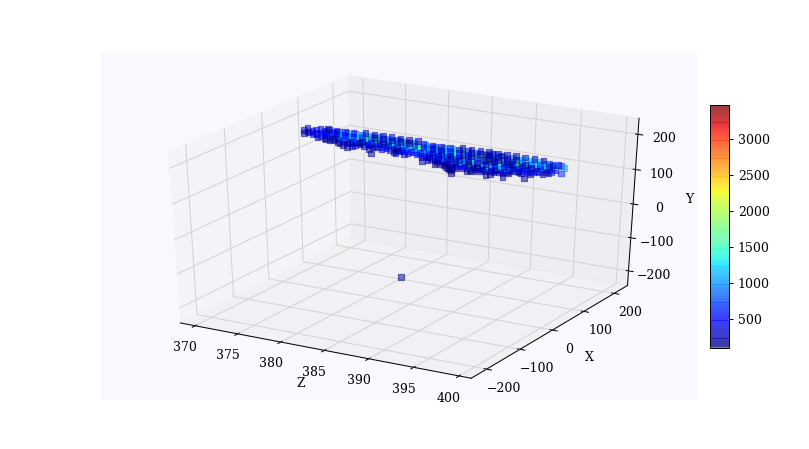

In [9]:
im = IMAGE(imagedf, datasipm, run, evt, typo)
im.plot3d()
im.fig.show();

<IPython.core.display.Javascript object>


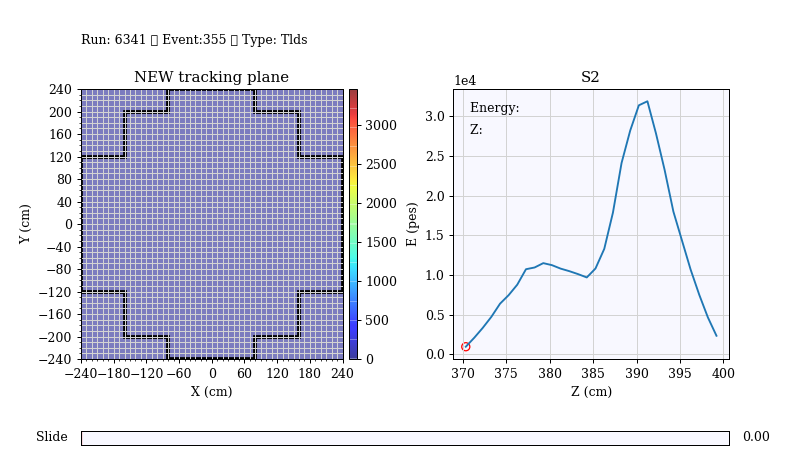

In [10]:
im = IMAGE(imagedf, datasipm, run, evt, typo)
im.Movie_Slider()
im.fig.show()

# Rebined image

In [11]:
rx, ry = 1, 1
zd = -1
imdf = vx.imageDataFrame(imagedf, datasipm, rx, ry, zd, th=0)

<IPython.core.display.Javascript object>


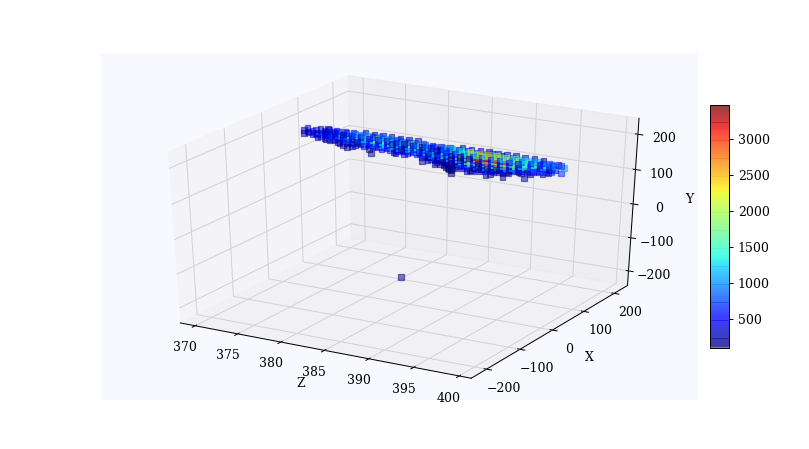

In [12]:
im = IMAGE(imdf, datasipm, run, evt, typo)
im.plot3d()
im.fig.show();

# Altogether

In [13]:
run = 6341
data = pd.HDFStore(f'../DATA/cepks_{run}_0000_11999_6q0min.h5')['/esum']

#photopeak region for run
a, b = 3.8e5, 4.3e5
thds = data[(a<data['e'])&(data['e']<b)]
evts, pks, locs = thds['event'].values, thds['peak'].values, thds['location'].values

In [63]:
#select a single event and peak
typo = 'Tlds'
i=0
evt, pk, loc = evts[i], pks[i], locs[i]
loc = '{:04}'.format(loc)

#input and correction files
correction_filename = f'/home/gonzalo/Documentos/NEXT/DATA/maps/kr_corrections_run{run}.h5'
input_filename = f'/home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_{loc}_{run}_trigger2_v0.9.9_20180921_krbg1300.h5'

#imagedf
_, cepk = cepeak(run, input_filename, correction_filename, evt, pk, q0min=6)
xij, yij, zij, eij = cepk.xij, cepk.yij, cepk.zij, cepk.eij
imagedf = pd.DataFrame(columns=['X', 'Y', 'Z', 'E'])
imagedf['X'], imagedf['Y'], imagedf['Z'], imagedf['E'] = xij, yij, zij, eij


#rebinned imagedf
rx, ry = 1, 1
zd = -1
datasipm = DataSiPM(run)
imdf = vx.imageDataFrame(imagedf, datasipm, rx, ry, zd, th=0)

processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0001_6341_trigger2_v0.9.9_20180921_krbg1300.h5


<IPython.core.display.Javascript object>


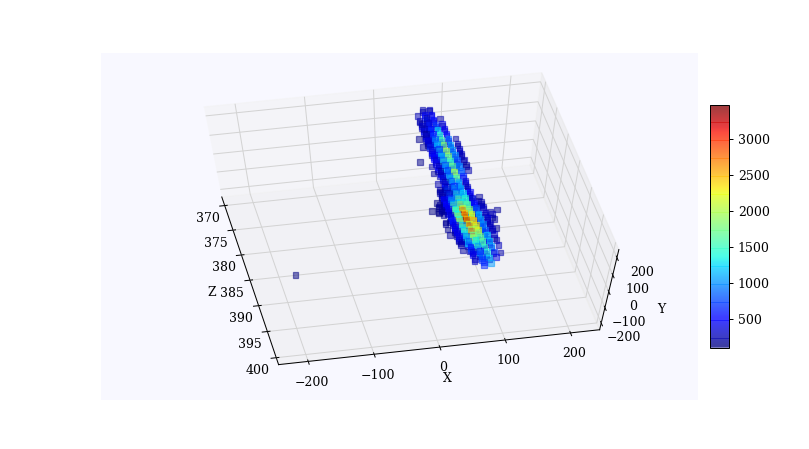

In [64]:
datasipm = DataSiPM(run)
im = IMAGE(imdf, datasipm, run, evt, typo)
im.plot3d(th=0)
im.fig.show();

In [47]:
ax = im.fig.axes[0]
R=10

In [52]:
Eb=[]
i=0
while i<1:
    blobdf, imdf_nb = bl.blob(imdf, R)
    
    X, Y, Z = blobdf['X'], blobdf['Y'], blobdf['Z']
    ax.scatter(Z, X, Y, c='black', s=200)
    
    Eb.append(blobdf['E'].sum())
    imdf = imdf_nb
    i+=1

In [53]:
im.fig.show()

# 3. BLOB CALCULATION

In [45]:
rx, ry = 1, 1
zd = -1
R=10

In [46]:
run = 6341
data = pd.HDFStore(f'../DATA/cepks_{run}_0000_11999_6q0min.h5')['/esum']
datasipm = DataSiPM(run)

#inputdir
#outputdir
#correctiondir

#photopeak region for run
a, b = 3.8e5, 4.3e5
thds = data[(a<data['e'])&(data['e']<b)]
evts, pks, locs = thds['event'].values, thds['peak'].values, thds['location'].values

In [47]:
blobsdf = pd.DataFrame(columns=['event', 'peak', 'loc', 'E1', 'E2', 'E3'])

In [48]:
j=1
# LOOP IN EVENTS
for evt, pk, loc in zip(evts, pks, locs):
    loc = '{:04}'.format(loc)
    
    #input and correction files
    correction_filename = f'/home/gonzalo/Documentos/NEXT/DATA/maps/kr_corrections_run{run}.h5'
    input_filename = f'/home/gonzalo/Documentos/NEXT/DATA/{run}/pmaps/trigger2/pmaps_{loc}_{run}_trigger2_v0.9.9_20180921_krbg1300.h5'

    #imagedf
    _, cepk = cepeak(run, input_filename, correction_filename, evt, pk, q0min=6)
    xij, yij, zij, eij = cepk.xij, cepk.yij, cepk.zij, cepk.eij
    imagedf = pd.DataFrame(columns=['X', 'Y', 'Z', 'E'])
    imagedf['X'], imagedf['Y'], imagedf['Z'], imagedf['E'] = xij, yij, zij, eij


    #rebinned imagedf
    rx, ry = 1, 1
    zd = -1
    datasipm = DataSiPM(run)
    imdf = vx.imageDataFrame(imagedf, datasipm, rx, ry, zd, th=0)
    
    #EVENT BLOB CALC
    Eb=[]
    i=0
    while i<3:
        blobdf, imdf_nb = bl.blob(imdf, R)
        Eb.append(blobdf['E'].sum())
        imdf = imdf_nb
        i+=1
        
    blobsdf = blobsdf.append({'event':evt, 'peak':pk, 'loc':loc, 'E1':Eb[0], 'E2':Eb[1], 'E3':Eb[2]}, ignore_index=True)
    
    print(f'Events saved:{j}/{len(thds)}', end = '\r')
    j+=1

processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0001_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0013_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0016_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0018_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0018_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0020_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0027_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0028_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEX

/home/gonzalo/Documentos/NEXT/ICAROS/csth/utils/cepeak.py:426: RuntimeWarning: invalid value encountered in true_divide
  eij[kslice] = qij[kslice] * e0i[k]/qi[k]


processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0047_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0047_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0048_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0049_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0054_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0059_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0059_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0061_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEX

processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0157_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0158_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0158_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0159_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0160_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0162_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0162_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0162_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEX

processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0283_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0287_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0287_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0290_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0294_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0294_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0298_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEXT/DATA/6341/pmaps/trigger2/pmaps_0299_6341_trigger2_v0.9.9_20180921_krbg1300.h5
processing  /home/gonzalo/Documentos/NEX

OSError: 

In [28]:
if zd<0: filename=f'blobsdf_{run}_{typo}_{R}_{rx}_{ry}_no.h5'
else   : filename=f'blobsdf_{run}_{typo}_{R}_{rx}_{ry}_{zd}.h5'
blobsdf.to_hdf(filename, key = 'blobs')